Based on this:
https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

In [1]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


In [2]:
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [3]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [5]:
# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [6]:
# PT
# model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained("./sentimentmodel/.")

In [7]:
# model.save_pretrained("sentimentmodel")

In [8]:
text = "i hate covid"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [9]:
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) negative 0.9622
2) neutral 0.0309
3) positive 0.0068


In [10]:
def give_labels(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        print(f"{i+1}) {l} {np.round(float(s), 4)}")

In [11]:
def give_most_probable_label(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    return labels[ranking[0]]

In [12]:
def label_probabilities(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    probs = {}
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        probs[l] = s
    return probs

In [13]:
label_probabilities("Good night 😊")

{'positive': 0.84657764, 'neutral': 0.14581239, 'negative': 0.0076098805}

In [14]:
give_labels("Good night 😊")

1) positive 0.8466
2) neutral 0.1458
3) negative 0.0076


In [15]:
give_most_probable_label("fuck you")

'negative'

In [16]:
import pandas as pd

# insert the filename below!!

In [17]:
filename = 'tweets_labeled_all.xlsx'

In [18]:
n = 2614
d = pd.read_excel(filename)
tweets = d['full_text'][:n]
# labels = d['Label (critical: 1/neutral: 0)'][:600]
# data = pd.DataFrame({'tweets': tweets, 'labels': labels})
critic_labels = d['Label (critical: 1/neutral: 0)'][:n]
data = pd.DataFrame({'tweets': tweets, 'labels': critic_labels})


In [19]:
n = 10
for t, l in zip(tweets[:n], critic_labels[:n]):
    print("TWEET:")
    print(t)
    print("scores by BERT model:")
    give_labels(t)
    label = "critical" if l == 1 else "neutral"
    print("MANUAL LABEL: ", end="")
    print(label)
    print("\n")

TWEET:
RT @MeenaDasNarayan: You are a scamster, who has cheated people using #Covid as a ruse... why would anyone trust even a curly knot in ur ha…
scores by BERT model:
1) negative 0.9506
2) neutral 0.0462
3) positive 0.0032
MANUAL LABEL: critical


TWEET:
RT @EricWishart: Because of #COVID, the mask shop is closed.
#HongKong #China https://t.co/FYcJX1pzNK
scores by BERT model:
1) neutral 0.4889
2) negative 0.4868
3) positive 0.0243
MANUAL LABEL: critical


TWEET:
RT @KentPage: Amidst deadly conflict and #COVID-19, heroic health workers at this underground maternity unit in Kharkiv are helping bring n…
scores by BERT model:
1) neutral 0.6801
2) positive 0.2748
3) negative 0.0451
MANUAL LABEL: neutral


TWEET:
RT @phyz_Buni: The suppression of #Ivermectin will be one of the biggest #COVID pandemic scandals. Dr John Campbell analysis of peer review…
scores by BERT model:
1) negative 0.7245
2) neutral 0.2575
3) positive 0.018
MANUAL LABEL: neutral


TWEET:
Total Covid Death Distribution 

## kaikkien twiittien jakauma

9.56% of tweets are positive
65.26% of tweets are neutral
25.17% of tweets are negative

In [20]:
def distribution(tweets):
    """
    percentage of positive/neutral/negative tweets
    """
    n = len(tweets)
    n_pos = 0
    n_neu = 0
    n_neg = 0
    for t in tweets:
        l = give_most_probable_label(t)
        if l == "positive":
            n_pos += 1
        elif l == "neutral":
            n_neu += 1
        elif l == "negative":
            n_neg += 1
    return n_pos/n, n_neu/n, n_neg/n

In [21]:
pos, neu, neg = distribution(tweets)
print(f"{pos*100:.2f}% of tweets are positive")
print(f"{neu*100:.2f}% of tweets are neutral")
print(f"{neg*100:.2f}% of tweets are negative")

9.56% of tweets are positive
65.26% of tweets are neutral
25.17% of tweets are negative


## critical tweets
12.39% of critical tweets are positive
41.45% of critical tweets are neutral
46.15% of critical tweets are negative

In [22]:
# critical tweets
tweets_critical = data[data['labels'] == 1]['tweets']
pos, neu, neg = distribution(tweets_critical)

In [23]:
print(f"{pos*100:.2f}% of critical tweets are positive")
print(f"{neu*100:.2f}% of critical tweets are neutral")
print(f"{neg*100:.2f}% of critical tweets are negative")

12.39% of critical tweets are positive
41.45% of critical tweets are neutral
46.15% of critical tweets are negative


## neutral tweets
8.53% of neutral tweets are positive
74.01% of neutral tweets are neutral
17.47% of neutral tweets are negative

In [24]:
tweets_neutral = data[data['labels'] == 0]['tweets']
pos, neu, neg = distribution(tweets_neutral)
print(f"{pos*100:.2f}% of neutral tweets are positive")
print(f"{neu*100:.2f}% of neutral tweets are neutral")
print(f"{neg*100:.2f}% of neutral tweets are negative")

8.53% of neutral tweets are positive
74.01% of neutral tweets are neutral
17.47% of neutral tweets are negative


In [25]:
def find_n_most_probable(tweets, n, label):
    """
    finds n most probable tweets with the given label.
    Example: find_n_most_probable(tweets_critical, 5, 'positive')
    returns 5 most positive critical tweets
    """
    tweetProbs = [] # list of tuples (tweet, probability)
    for t in tweets:
        probs = label_probabilities(t)
        tweetProbs.append((t, probs[label]))
    # order list by prob, most probable first
    tweetProbs = sorted(tweetProbs, key=lambda x: x[1], reverse=True)
    # return only the n first tweets
    # print(tweetProbs[:n])
    return [t[0] for t in tweetProbs[:n]]

In [26]:
critical_positive = find_n_most_probable(tweets_critical, 5, 'positive')

In [27]:
def print_nicely(tweets, labels = None):
    for i, t in enumerate(tweets):
        print(t)
        if labels is not None:
            print(f"LABEL: {labels.iloc[i]}")
        print("---------------------------------")

In [28]:
print_nicely(critical_positive)

RT @AilsaForshaw: #FoodieFriday #YangGangFitness #YangGang 

Yum! Time to make more #CoffeeCake! Is so delicious, #Cinnamon is very good fo…
---------------------------------
Rainbow Print Protective Fask Masks

🌸https://t.co/AEYsyPOlVH

I mean have you seen anything more fun? These are way happier looking than the standard blue or white masks

#rainbow #covid https://t.co/TsOCS3mqur https://t.co/B7JWcOgUSf
---------------------------------
Happiness can be found even in the darkest of times if one only remembers to turn on the light.

 #inspiration #therapy #happiness #positivity #positivevibes #mindset #quotes #meditation #mentalillness #psychology #wellbeing #instagood #covid #bhfyp
---------------------------------
Happiness can be found even in the darkest of times, if one only remembers to turn on the light. 

#inspiration #therapy #happiness #positivity #positivevibes #mindset #quotes #meditation #mentalillness #psychology #wellbeing #instagood #covid #bhfyp
--------------------

- can't detect sarcasm well
- claims may seem positive, even though they may be somewhat false and contain words with positive connotations (teachers, education, etc.)

In [29]:
critical_negative = find_n_most_probable(tweets_critical, 5, 'negative')

In [30]:
print_nicely(critical_negative)

At the end of the day, I have no fucking 𝒄𝒉𝒐𝒊𝒄𝒆. The CUNT follows 𝒎𝒆 around absolutely every fucking where like a fucking dog turd I picked up on my shoe.
#McClownTheDogTurd #CovidDeathCult #COVID https://t.co/nvxo20NpNl
---------------------------------
You are a scamster, who has cheated people using #Covid as a ruse... why would anyone trust even a curly knot in ur hair??? @RanaAyyub https://t.co/mvgTLnMt4x
---------------------------------
The most weird and annoying side effect of Covid is that all fruit now has a strange floral taste. 🙄 Sound familiar to anyone? #covid #sideeffects #taste
---------------------------------
@Rusty02163858 @brooklyndumbo You humans have been getting sick from coronavirus your entire lives and your reactions to the common cold, bronchitis, pneumonia are that of Stupidity.

#ThisIsWhyWeDontVisitYou
#Scamdemic
#COVID
#LetsGoDarwin
#1YearOfVaccination
#VaccineInjuries
#VaccineDrunk
#COVIDdrugAdicts
---------------------------------
A few weeks ago, I st

- not surprising. blaiming, critical, very negative words and claims

In [31]:
critical_neutral = find_n_most_probable(tweets_critical, 5, 'neutral')

In [32]:
print_nicely(critical_neutral)

Any #Covid Discordant Couples here in Hong Kong??
---------------------------------
RT @Aaron_Derfel: Hi everyone: The Evening Owl will be dropping a #COVID Twitter thread momentarily, returning to the subject of the fallou…
---------------------------------
RT @Aaron_Derfel: Hi everyone: The Evening Owl will be dropping a #COVID Twitter thread momentarily, returning to the subject of the fallou…
---------------------------------
RT @Aaron_Derfel: Hi everyone: The Evening Owl will be dropping a #COVID Twitter thread momentarily, returning to the subject of the fallou…
---------------------------------
RT @Aaron_Derfel: Hi everyone: The Evening Owl will be dropping a #COVID Twitter thread momentarily, returning to the subject of the fallou…
---------------------------------


- questioning claims/questions, no provocative words
- sarcasm may be involved
- may be very critical, but with no negative words

In [33]:
neutral_negative = find_n_most_probable(tweets_neutral, 5, 'negative')

kaikista twiiteistä, mitkä on kaikkein pos/neg, ovatko kriittisiä vai neutraaleja?

In [34]:
print_nicely(neutral_negative)

The highly dangerous #COVID virus has infected my youngest child. Here he is suffering in isolation. https://t.co/wzOweynfBg
---------------------------------
that they are actually destroying their children's lives;  the impact on humans brought by those over a thousand side effects of the COVID vaccine recently released by the FDA will be multiplied, and the death toll will be unpredictable.

#COVID
#FDA https://t.co/wwljfwISlM
---------------------------------
🤡🍿🎪 @andrewcuomo serially sexually harassed multiple women, resigned to avoid being impeached, still blames victims, refuses to take responsibility &amp; enabled nursing home owners to kill  1000s during #COVID  w/no consequences. Horrific #pandemicpatriarch. @monaeltahawy https://t.co/CsnRrY5cUZ
---------------------------------
Fuckin GI virus, unless it's COVID, home tests come negative. Fever 38+, diarrea, vomits, body aches, shivers. Anybody relate? @yyc @Crackmacs #COVID #NotCovid #whoknows
------------------------------

- ugly words
- critical/thought-provoking text but not about covid

In [35]:
# construct a df with all tweets and probabilities
pos_probs = []
neu_probs = []
neg_probs = []
positivity_labels = []
for t in tweets:
    probs = label_probabilities(t)
    pos_probs.append(probs['positive'])
    neu_probs.append(probs['neutral'])
    neg_probs.append(probs['negative'])
    positivity_labels.append(max(probs, key=probs.get))
df = pd.DataFrame({'tweets': tweets, 'criticality_label': critic_labels, 'positivity_label': positivity_labels, 'pos_prob': pos_probs, 'neu_prob': neu_probs, 'neg_prob': neg_probs})

In [36]:
df['criticality_label'] = df['criticality_label'].map({1: 'critical', 0: 'neutral'})

In [37]:
# most positive tweets
df.sort_values(by=['pos_prob'], ascending=False, inplace=True)
# print(df.head(10))
n = 5
print(f"{n} most positive tweets:")
print_nicely(df['tweets'][:n], df['criticality_label'][:n])

5 most positive tweets:
Thank you, @60Minutes, for an uplifting stream of info tonight. After watching @10queues and @CDCDirector, I am, this time, more understanding of the nature of #Covid; and that we really are in a better place currently.
LABEL: neutral
---------------------------------
RT @NinjaJuice10: @AltcoinWorldcom We all can party again thanks to the @BackstageBks and this amazing concept that brings life to event in…
LABEL: neutral
---------------------------------
RT @esthersingsjazz: Really enjoyed contributing to this book! 😎 #jazzsinger #jazzlife #jazzbooks #jazzwriting #COVID #lockdownlife https:/…
LABEL: neutral
---------------------------------
@pascal_bornet thanx for sharing this! On a lighter note - Working from home these past two years we have to be thankful the universe has at the very least continued to move! 🙂 Time to contribute to our part!! #workingfromhome #covid #amazing #universe https://t.co/OBSf6KG9TF
LABEL: neutral
---------------------------------
R

- not surprisingly, no criticality
- praising band, returning to a public place or wfh possibilities, more about general situation of pandemic than the disease
- 

In [38]:
# most neutral tweets
df.sort_values(by=['neu_prob'], ascending=False, inplace=True)
print(f"{n} most neutral tweets:")
print_nicely(df['tweets'][:n], df['criticality_label'][:n])

5 most neutral tweets:
Any #Covid Discordant Couples here in Hong Kong??
LABEL: critical
---------------------------------
RT @NewsMedical: Longitudinal analysis of CD4+ T cells and antibody responses to common cold coronaviruses https://t.co/wiydXa9E2t @biorxiv…
LABEL: neutral
---------------------------------
RT @NewsMedical: Longitudinal analysis of CD4+ T cells and antibody responses to common cold coronaviruses https://t.co/wiydXa9E2t @biorxiv…
LABEL: neutral
---------------------------------
Central Delhi has at least 9058 new slots available between 07-03-22 &amp; 14-03-22.

Covishield:
Dose1- 18+/45+:1238/0
Dose2- 18+/45+:1274/0

Covaxin:
Dose1- 18+/45+:0/0
Dose2- 18+/45+:0/0

Book one now at https://t.co/oN1Ae9Fz77 #vaccine #cowin #covid #Delhi
LABEL: neutral
---------------------------------
RT @researchsaves: Early in 2020, Riti Sharan worked 12 hours a day, seven days a week in biocontainment safety level 3 labs at Texas Biome…
LABEL: neutral
-------------------------------

- news reports

In [39]:
# most negative tweets
df.sort_values(by=['neg_prob'], ascending=False, inplace=True)
print(f"{n} most negative tweets:")
print_nicely(df['tweets'][:n], df['criticality_label'][:n])

5 most negative tweets:
At the end of the day, I have no fucking 𝒄𝒉𝒐𝒊𝒄𝒆. The CUNT follows 𝒎𝒆 around absolutely every fucking where like a fucking dog turd I picked up on my shoe.
#McClownTheDogTurd #CovidDeathCult #COVID https://t.co/nvxo20NpNl
LABEL: critical
---------------------------------
The highly dangerous #COVID virus has infected my youngest child. Here he is suffering in isolation. https://t.co/wzOweynfBg
LABEL: neutral
---------------------------------
You are a scamster, who has cheated people using #Covid as a ruse... why would anyone trust even a curly knot in ur hair??? @RanaAyyub https://t.co/mvgTLnMt4x
LABEL: critical
---------------------------------
The most weird and annoying side effect of Covid is that all fruit now has a strange floral taste. 🙄 Sound familiar to anyone? #covid #sideeffects #taste
LABEL: critical
---------------------------------
that they are actually destroying their children's lives;  the impact on humans brought by those over a thousand side 

- blaiming, trashtalk
- tweet about war containing negative connotated (but not inpolite) words

In [40]:
# plot some nice distributions
import matplotlib.pyplot as plt


In [41]:
# plot stacked histograms about probability distribution and criticality
def plot_distribution(df, label):
    criticals = df[df['criticality_label'] == 'critical'][label]
    neutrals = df[df['criticality_label'] == 'neutral'][label]
    x = [criticals, neutrals]
    plt.hist(x, stacked=True, bins=20)
    plt.legend(['critical tweets', 'neutral tweets'])
    plt.xlabel("Probability")
    plt.ylabel("Number of tweets")
    if label == 'pos_prob':
        plt.title("Positive probability distribution")
    elif label == 'neu_prob':
        plt.title("Neutral probability distribution")
    elif label == 'neg_prob':
        plt.title("Negative probability distribution")

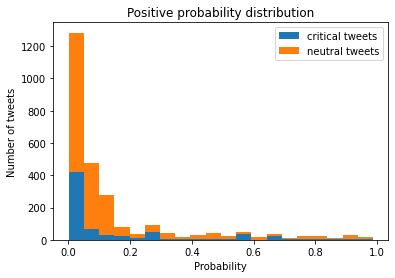

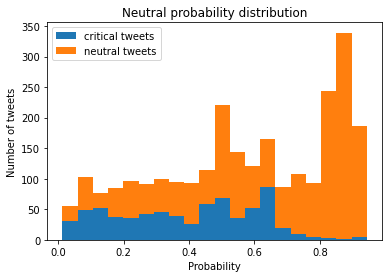

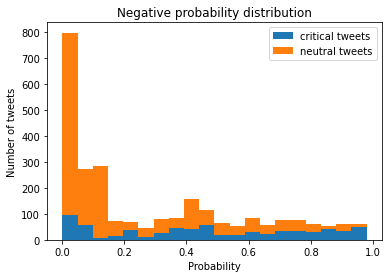

In [42]:
plot_distribution(df, 'pos_prob')
plt.show()
plot_distribution(df, 'neu_prob')
plt.show()
plot_distribution(df, 'neg_prob')
plt.show()

In [43]:
# plot bar chart about pos/neg/neu and criticality
def stackedBar(df):
    labels = ['positive', 'neutral', 'negative']
    # underhood_labels = ['pos_prob', 'neu_prob', 'neg_prob']
    criticals = df[df['criticality_label'] == 'critical']
    neutrals = df[df['criticality_label'] == 'neutral']
    x = [criticals[criticals['positivity_label'] == l].shape[0] for l in labels]
    y = [neutrals[neutrals['positivity_label'] == l].shape[0] for l in labels]
    plt.bar(labels, x, color='r', label='critical tweets')
    plt.bar(labels, y, color='b', bottom=x, label='neutral tweets')
    plt.xlabel("Positivity label")
    plt.ylabel("Number of tweets")
    plt.title("Positivity distribution")
    plt.legend()
    plt.show()
    

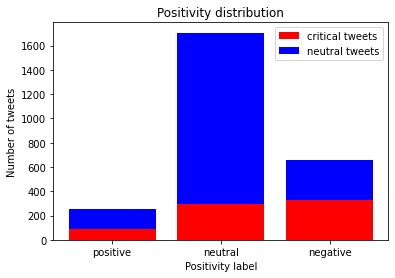

In [44]:
stackedBar(df)